In [11]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

load_dotenv()


True

In [12]:
class sentiStructure(BaseModel):
    senti : Literal['pos', 'neg'] = Field(description= "Analyze sentiment of the review and classify it into pos or neg")
    
class diagStructure(BaseModel):
    issue_type: str = Field(description= "what is the issue type of the review")
    tone: str = Field(description= "What is the tone of the customer")
    urgency: str = Field(description= "analyze the urgency of the cutomer")

In [13]:
model = ChatGoogleGenerativeAI(model= "models/gemini-2.0-flash")
senti_model = model.with_structured_output(sentiStructure)
diagnosis_model = model.with_structured_output(diagStructure)

In [14]:
# senti_model.invoke("what the fuck is this product...")
# diagnosis_model.invoke("what the fuck is this product...")

In [15]:
class graphState(TypedDict):
    review : str
    sentiment: str
    
    issue_type: str
    tone: str
    urgency: str
    
    llm_res: str

In [16]:
def find_sentiment(state: graphState):
    res = senti_model.invoke(f"Based on the review find the sentiment \n {state["review"]}")
    return {"sentiment": res.senti}

def run_diagnosis(state: graphState):
    res = diagnosis_model.invoke(f"Based on the review find the issue type, tone and urgency \n {state["review"]}")
    return {"issue_type": res.issue_type, "tone": res.tone, "urgency": res.urgency}

def neg_response(state: graphState):
    res = model.invoke(f"Based on the issue type \n {state["issue_type"]} \n tone {state["tone"]} \n urgency {state["urgency"]} \n of the customer write a appology response for the review {state["review"]}")
    return {"llm_res": res.content}

def pos_response(state: graphState):
    res = model.invoke(f"Write a positive response for the reivew {state["review"]}")
    return {"llm_res": res.content}

def condition(state: graphState) -> Literal['run_diagnosis', 'pos_response']:
    if state['sentiment'] == 'pos':
        return "pos_response"
    return "run_diagnosis"

In [17]:
graph = StateGraph(graphState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('neg_response', neg_response)
graph.add_node('pos_response', pos_response)

graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", condition)
graph.add_edge("run_diagnosis", "neg_response")
graph.add_edge("neg_response", END)
graph.add_edge("pos_response", END)

wokflow = graph.compile()

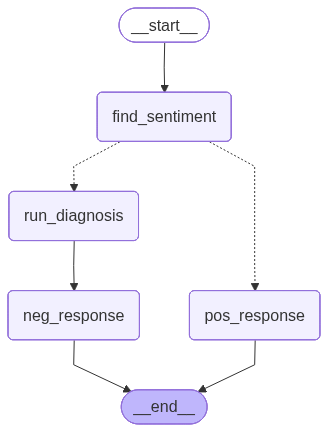

In [18]:
wokflow

In [19]:
final_state = wokflow.invoke({
    "review": '"I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."',
    "sentiment": '',
    "issue_type": '',
    "tone": '',
    "urgency": '',
    "llm_res": '',
})

In [20]:
final_state

{'review': '"I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."',
 'sentiment': 'neg',
 'issue_type': 'Authentication issue',
 'tone': 'Frustrated',
 'urgency': 'High',
 'llm_res': 'Okay, here\'s an apology response tailored to the customer\'s review, considering the "Authentication issue," "Frustrated" tone, and "High" urgency:\n\n**Response:**\n\n"We are so sorry you\'re experiencing this frustrating login issue. We understand how incredibly disruptive it is when you can\'t access the app, especially after trying to troubleshoot it yourself. An hour is far too long to be locked out, and we sincerely apologize for the inconvenience and frustration this has caused.\n\nWe\'ve identified a potential authentication issue impacting some users, and our team is working urgently to resolve it.  We know this isn\'t 

In [ ]:
{'review': '"I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."',
 'sentiment': 'neg',
 'issue_type': 'Authentication issue',
 'tone': 'Frustrated',
 'urgency': 'High',
 'llm_res': 'Okay, here\'s an apology response tailored to the customer\'s review, considering the "Authentication issue," "Frustrated" tone, and "High" urgency:\n\n**Response:**\n\n"We are so sorry you\'re experiencing this frustrating login issue. We understand how incredibly disruptive it is when you can\'t access the app, especially after trying to troubleshoot it yourself. An hour is far too long to be locked out, and we sincerely apologize for the inconvenience and frustration this has caused.\n\nWe\'ve identified a potential authentication issue impacting some users, and our team is working urgently to resolve it.  We know this isn\'t acceptable, and we\'re treating this as a top priority.\n\nIn the meantime, could you please provide us with [mention specific information that can help diagnose. Examples: your device type and OS version, the last time you successfully logged in, or any error messages you\'re seeing]? This information will help us pinpoint the cause and get you back up and running as quickly as possible.\n\nWe\'ll provide updates on the progress toward a solution within [Time frame. Example: the next hour/2 hours/30 minutes]. Thank you for your patience and understanding as we work to fix this.\n\nAgain, we sincerely apologize for this unacceptable experience."'}